In [ ]:
pip install googletrans==3.1.0a0 --upgrade --quiet

In [2]:
# importing the important library
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk 
import re
import seaborn as sns
from googletrans import Translator, constants
from pprint import pprint
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from scipy.sparse import hstack
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
project_data = pd.read_csv('HOT_Dataset_modified.csv', encoding='utf-8', header=None)
project_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.0,@saud5683 @Mutayyab420 @shivang598 @Ranask35 @...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,"Banti hai empowered woman, feminism pe gyan pe...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,RT @kim_jong_korea: @updatingwait @Acutereply ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
project_data = project_data.dropna(how='all')

In [5]:
project_data = project_data.iloc[0::, 0:2]

In [6]:
project_data[0].value_counts()

2.0    1765
0.0    1121
1.0     303
Name: 0, dtype: int64

In [7]:
project_data.columns = ['label', 'tweet']

In [8]:
project_data.isnull().any()

label    False
tweet    False
dtype: bool

# Exploratory Data Analysis 

Number of tweets that are Non Abusive 1121 , ( 35.152085293195356 %)
Number of tweets that are Hate Speech 303 , ( 9.501411100658514 %)
Number of tweets that are abusive 1765 , ( 55.34650360614612 %)


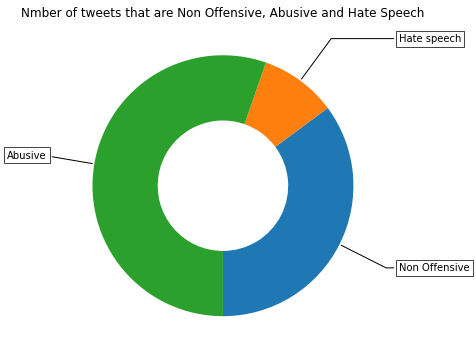

In [ ]:
# this code is taken from 
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py


y_value_counts = project_data['label'].value_counts()
print("Number of tweets that are Non Abusive", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[0]+y_value_counts[1]+y_value_counts[2]))*100,"%)")
print("Number of tweets that are Hate Speech", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]+y_value_counts[2]))*100,"%)")
print("Number of tweets that are abusive", y_value_counts[2], ", (", (y_value_counts[2]/(y_value_counts[1]+y_value_counts[0]+y_value_counts[2]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Non Offensive", "Hate speech", "Abusive"]

data = [y_value_counts[0], y_value_counts[1], y_value_counts[2]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-90)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Nmber of tweets that are Non Offensive, Abusive and Hate Speech")

plt.show()

## Visualization with number of words in Tweets

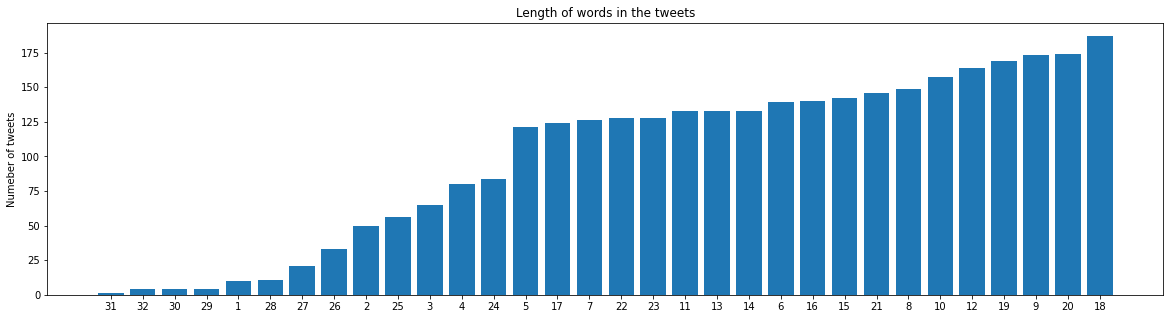

In [ ]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = project_data['tweet'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Numeber of tweets')
plt.title('Length of words in the tweets')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

The above help us to visualise the tweets according to the number of words. The length of tweet varies between 1 to 32 here. The maximum numbers of tweets is 175 according to length of words which 18.

In [ ]:
group_tweets = project_data.groupby('label')
non_offensive = group_tweets.get_group(0.0)
abusive = group_tweets.get_group(2.0)
hate_speech = group_tweets.get_group(1.0)

## Visualization as number of words in non_offensive tweets

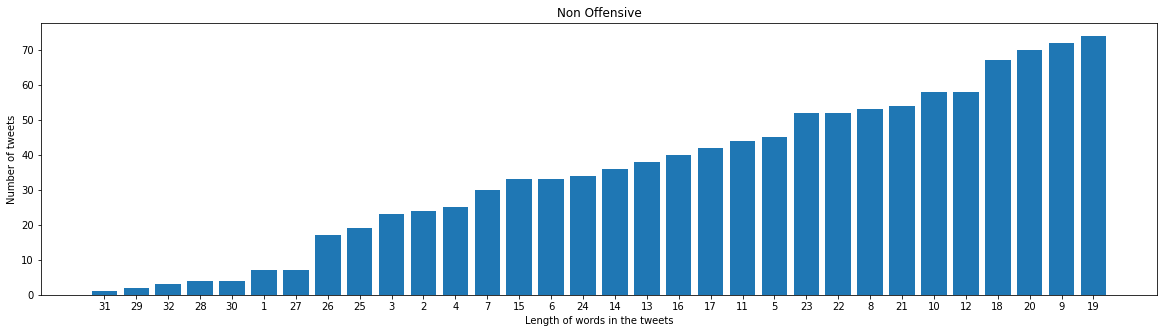

In [ ]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = non_offensive['tweet'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.xlabel('Length of words in the tweets')
plt.ylabel('Number of tweets')
plt.title('Non Offensive')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

In Non Offensive tweets, the maximum tweets is 70 of word lenght 19.

## Visualization as per number of words in abusive tweets

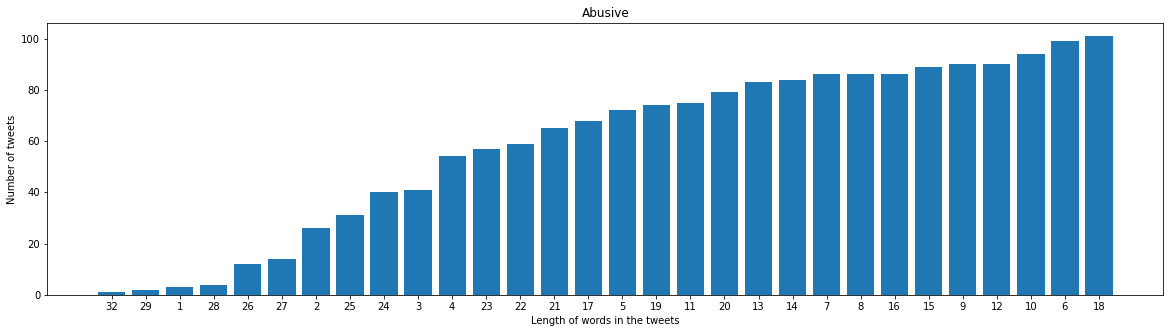

In [ ]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = abusive['tweet'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.xlabel('Length of words in the tweets')
plt.ylabel('Number of tweets')
plt.title('Abusive')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

In Abusive tweets, the maximum tweets is 100 of word lenght 18.

## Visualization as per number of words in hate speech tweets

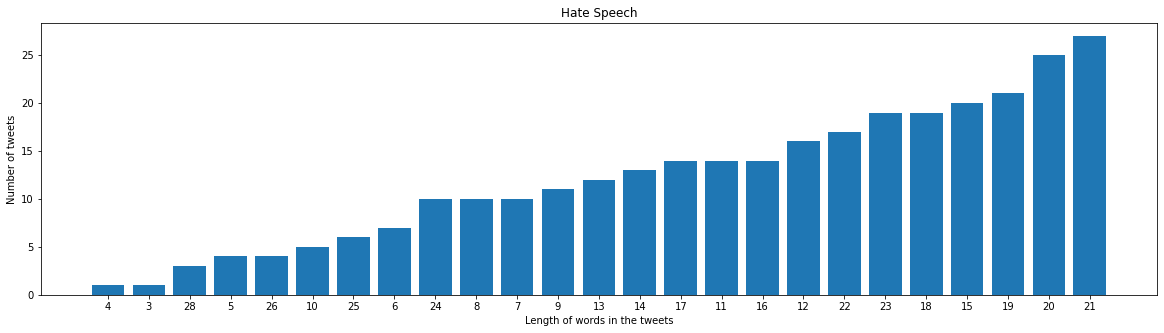

In [ ]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = hate_speech['tweet'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.xlabel('Length of words in the tweets')
plt.ylabel('Number of tweets')
plt.title('Hate Speech')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

## Box Plot with number of words in each categories of tweets

C:\Users\hp\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


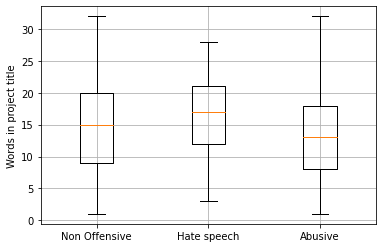

In [ ]:
non_offensive_word_count = non_offensive['tweet'].str.split().apply(len).values

hate_speech_word_count = hate_speech['tweet'].str.split().apply(len).values

abusive_word_count = abusive['tweet'].str.split().apply(len).values

# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([non_offensive_word_count, hate_speech_word_count, abusive_word_count])
plt.xticks([1,2,3],("Non Offensive", "Hate speech", "Abusive"))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

From Box Plots, we can analyse that the IQR of word length of tweets in hate speech are between 13 to 21. While the abusive are between 8 to 17 and the Non Offensive are between 9 to 20.

## PDF Plot with number of words in each categories of tweets

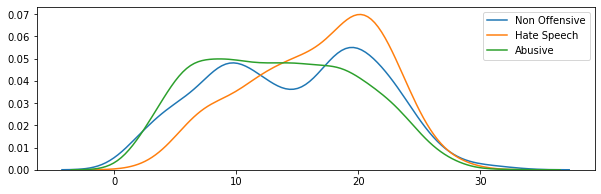

In [ ]:
plt.figure(figsize=(10,3))
sns.distplot(non_offensive_word_count, hist=False, label="Non Offensive")
sns.distplot(hate_speech_word_count, hist=False, label="Hate Speech")
sns.distplot(abusive_word_count, hist=False, label="Abusive")

plt.legend()
plt.show()

## Word Cloud for non_offensive tweets

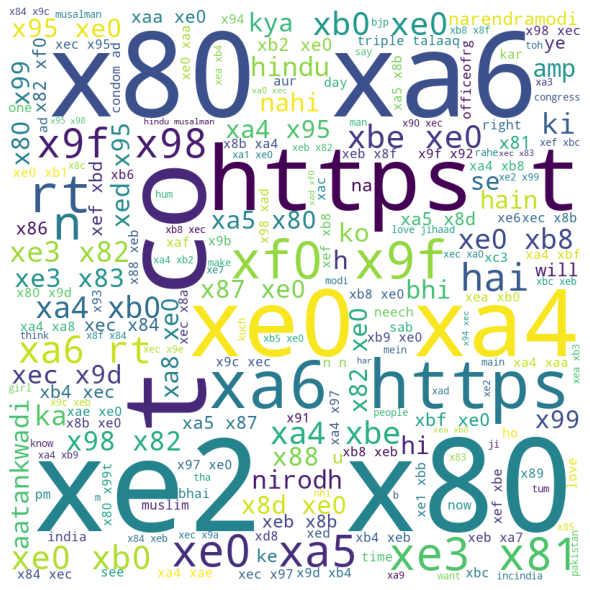

In [ ]:
# Python program to generate WordCloud

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in non_offensive['tweet']:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


## Word Cloud for abusive tweets

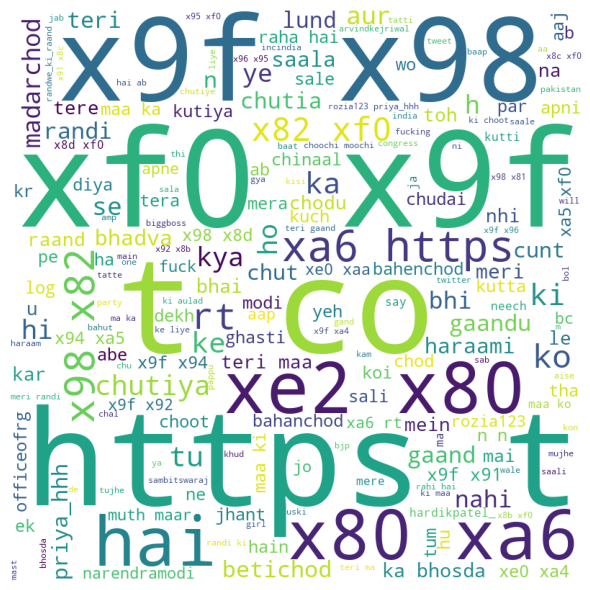

In [ ]:
# Python program to generate WordCloud

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in abusive['tweet']:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


## Word Cloud for Hate Speech tweets

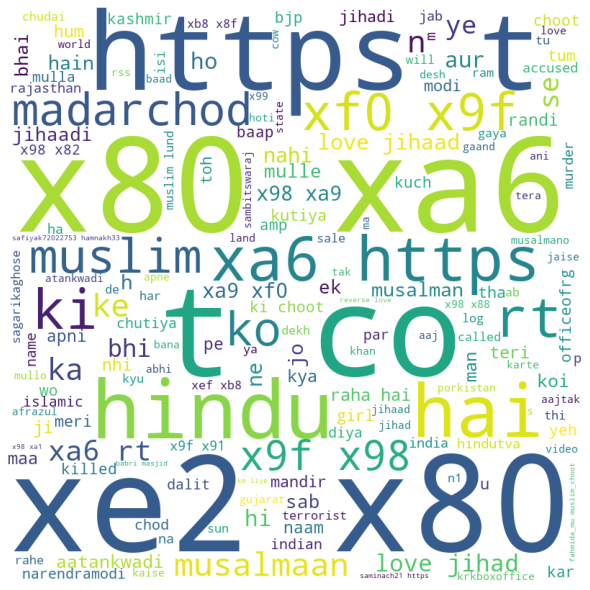

In [ ]:
# Python program to generate WordCloud

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in hate_speech['tweet']:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


## Function for Data Cleaning

In [9]:
def userid(tweet):
    ''' This function calculates the number of userids in the tweets'''
    count = 0
    for i in tweet.split():
        if i[0] == '@':
            count += 1
    return count

def profanity_vector(tweet):
    
    ''' This functions calculates the profanity vector for a given tweet '''
    
    bad_words = pd.read_csv('Hinglish_Profanity_List.csv', engine='python', header=None)
    bad_words.columns = ['Hinglish', 'English', 'Level']
    hinglish = bad_words['Hinglish'].values
    level = bad_words['Level'].values
    PV = [0] * len(level)
    for word in tweet.split():
        if word in hinglish:
            idx = np.where(hinglish == word)
            PV[level[idx][0]] = 1
    return PV

def translation(tweet):
    
    ''' This function translates the hinglish tweet into english '''
    translator = Translator()
    trans = translator.translate(tweet)
    trans_tweet = trans.text
    
    return trans_tweet.lower()

def stopword(data):
    
    ''' This function removes the stopwords from the given sentence'''
    clean = []
    stop_words = set(STOPWORDS)
    
    for tweet in data:
        sentence = []
        for word in tweet.split():
            if word not in stop_words:
                sentence.append(word)
        clean.append(sentence)
    return clean

def Lemmatizer(tweet):
    
    ''' This function uses NLTK lemmatization method and clean the sentence'''
    lemma = []
    lemmatizer = WordNetLemmatizer()
    
    for word in tweet:
        sentence = []
        for i in word:
             sentence.append(lemmatizer.lemmatize(i))
        lemma.append(' '.join(sentence))
    return lemma

def SID(tweet):
    
    ''' This function calculates the NLTK sentiments and return the negative, neutral, postive and compound values'''
    negative = []
    neutral = []
    positive = []
    compound = []
    
    sid = SentimentIntensityAnalyzer()
    sentiment_score = sid.polarity_scores(tweet)
    
    negative.append(sentiment_score['neg'])
    neutral.append(sentiment_score['neu'])
    positive.append(sentiment_score['pos'])
    compound.append(sentiment_score['compound'])
    
    return negative, neutral, positive, compound


def cleaning(data):
    
    ''' This functions clean the input text'''
    
    user_ids = []
    clean_data_hinglish = []
    clean_translated_data = []
    prof_vector = []
    
    for tweet in tqdm(data):
        userids = userid(tweet)
        clean_text = []
        tweet = re.sub(r'\\n', ' ', tweet)  # replacing '\\n' with a space
        tweet = re.sub(r',', ' ', tweet)    # replacing ','  with a space
        tweet = re.sub(r'RT|rt', '', tweet)
        
        for word in tweet.split():
            if word[0] == '@':              # removing user_ids 
                clean_word = re.sub(word, 'username', word)
            else:
                clean_word = word.lower()       # lowercase all the words
                clean_word = re.sub(r'^#\w+', ' ', clean_word)
                #clean_word = re.sub(r'^\\[a-z0-9].*\\[a-z0-9{3}+]*[^\\n]$', '', clean_word)   # removing emotions in unicode
                clean_word = re.sub(r'\\', ' ', clean_word)
                clean_word = re.sub(r'^https:[\a-zA-Z0-9]+', '', clean_word)              # replacing url link with 'url'
                #clean_word = re.sub(r'[^a-z].\w+', '', clean_word)           # removing evering thing except a-z
                clean_word = re.sub(r'[!,.:_;$%^\'\#"&]', '', clean_word)
                clean_text.append(clean_word)
                
        clean_text = (' ').join(clean_text)
    
        PV = profanity_vector(clean_text)  # calling profanity_vector function
        translated_tweet = translation(clean_text)  #calling translated_tweet function
        
        user_ids.append(userids)
        clean_data_hinglish.append(clean_text)
        clean_translated_data.append(translated_tweet)
        prof_vector.append(PV)
        
        
    clean_data_hinglish = np.asarray(clean_data_hinglish)
    user_ids = np.asarray(user_ids).reshape(-1,1)
    prof_vector = np.asarray(prof_vector)
    clean_translated_data = np.asarray(clean_translated_data)

        
    return clean_data_hinglish, user_ids, prof_vector, clean_translated_data

In [ ]:
# creating a dataframe with the clean data
dataframe_clean = pd.DataFrame(list(zip(clean_data_hinglish, clean_translated_data, project_data['label'].values)),\
                               columns=['Hinglish_Data_Clean', 'Translated_Data_Clean', 'Label'])

NameError: name 'clean_data_hinglish' is not defined

In [ ]:
#grouping with the target label

group_tweets_clean = dataframe_clean.groupby('Label')
non_offensive_clean = group_tweets_clean.get_group(0.0)
abusive_clean = group_tweets_clean.get_group(2.0)
hate_speech_clean = group_tweets_clean.get_group(1.0)

## Word Cloud for for Non_Offensive tweets after cleaning

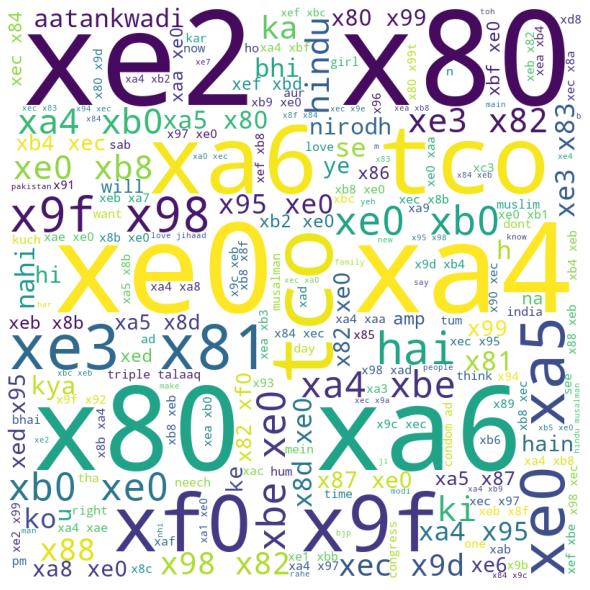

In [ ]:
# Python program to generate WordCloud only for Non_Offensive tweets after cleaning

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in non_offensive_clean['Hinglish_Data_Clean']:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


## Word Cloud for Abusive tweets after cleaning

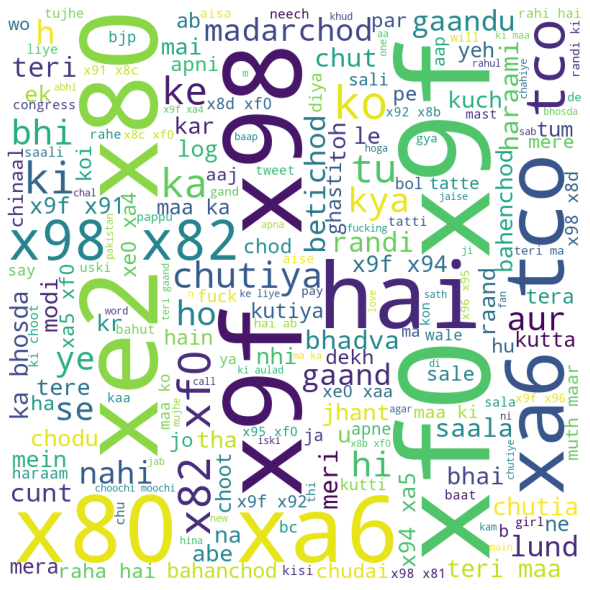

In [ ]:
# Python program to generate WordCloud only for Abusive tweets after cleaning

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in abusive_clean['Hinglish_Data_Clean']:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

## Word Cloud only for Hate Speech tweets after cleaning

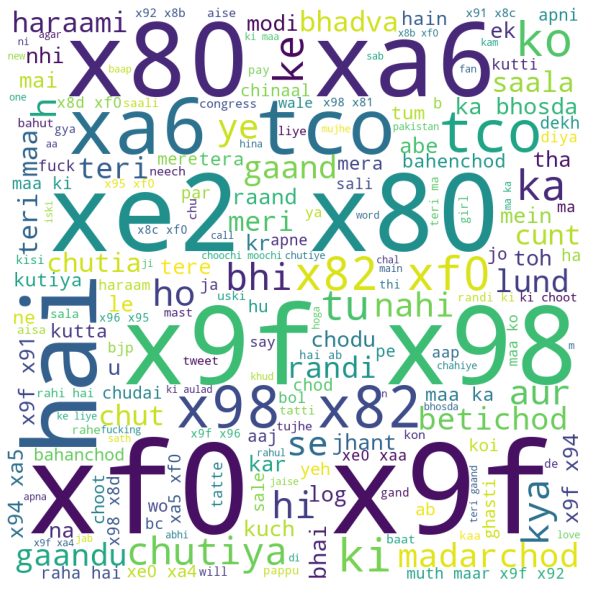

In [ ]:
# Python program to generate WordCloud only for Hate Speech tweets after cleaning

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in abusive_clean['Hinglish_Data_Clean']:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

### Function for feature Engineering

In [10]:
def feature_process(clean_data_train, clean_data_test, userids_train, userids_test, PV_train, PV_test):
    ''' This function except the clean data and return Train and Test dataset after stacking userids, profanity vector, negative sentiment, neutral sentiment, 
                    positive sentiment, compound sentiment, n-grams and tfidf features'''
    
    vectorizer = CountVectorizer()
    tfidf = TfidfVectorizer()
    negative_train, negative_test = [], []
    neutral_train, neutral_test = [], []
    positive_train, positive_test  = [], []
    compound_train, compound_test  = [], []

    for tweet in clean_data_train:
        neg, neu, pos, comp = SID(tweet)
        negative_train.append(neg), neutral_train.append(neu), positive_train.append(pos), compound_train.append(comp)
    
    for tweet in clean_data_test:
        neg, neu, pos, comp = SID(tweet)
        negative_test.append(neg), neutral_test.append(neu), positive_test.append(pos), compound_test.append(comp)
    
    clean_data_SW_train = stopword(clean_data_train)
    clean_data_SW_test = stopword(clean_data_test)
    
    clean_data_lemm_train = Lemmatizer(clean_data_SW_train)
    clean_data_lemm_test = Lemmatizer(clean_data_SW_test)
    
    vectorizer.fit(clean_data_lemm_train)
    tfidf.fit(clean_data_lemm_train)
    
    n_grams_train = vectorizer.transform(clean_data_lemm_train)
    tfidf_ngrams_train = tfidf.transform(clean_data_lemm_train)
    
    n_grams_test = vectorizer.transform(clean_data_lemm_test)
    tfidf_ngrams_test = tfidf.transform(clean_data_lemm_test)
    
    negative_train, negative_test = np.asarray(negative_train), np.asarray(negative_test)
    neutral_train, neutral_test = np.asarray(neutral_train), np.asarray(neutral_test)
    positive_train, positive_test  = np.asarray(positive_train), np.asarray(positive_test)
    compound_train, compound_test = np.asarray(compound_train), np.asarray(compound_test)
    
    train_dataset = hstack((user_ids_train, PV_train, negative_train, neutral_train, positive_train, compound_train, n_grams_train, tfidf_ngrams_train))
    
    test_dataset = hstack((user_ids_test, PV_test, negative_test, neutral_test, positive_test, compound_test, n_grams_test, tfidf_ngrams_test))
    
    
    return train_dataset, test_dataset

## Spliting Train and Test Dataset into 80:20


In [11]:
X = project_data['tweet']
y = project_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) 

In [12]:
# calling the cleaning function which returns the values for the train dataset.

clean_data_hinglish_train, user_ids_train, prof_vector_train, clean_translated_data_train = cleaning(X_train)

100%|██████████| 2551/2551 [16:21<00:00,  2.60it/s]


In [13]:
# calling the cleaning function which returns the values for the test dataset

clean_data_hinglish_test, user_ids_test, prof_vector_test, clean_translated_data_test = cleaning(X_test)

100%|██████████| 638/638 [04:14<00:00,  2.50it/s]


In [14]:
#Calling feature_process which return the complete train and test dataset.

Train, Test = feature_process(clean_translated_data_train, clean_translated_data_test, user_ids_train, user_ids_test, prof_vector_train, prof_vector_test)

In [15]:
print('{} is the shape of Train Dataset and {} is the shape of Test Dataset'.format(Train.shape, Test.shape))

(2551, 14062) is the shape of Train Dataset and (638, 14062) is the shape of Test Dataset


## Trying our Models:

In [16]:
def plot_confusion_matrix(test_y, predict_y):
    
    '''This function returns confusion matrix, precison matrix and recall matrix for 3 class classification'''
    
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    
    labels = ['Non Offensive', 'Hate Speech', 'Abusive']
    cmap=sns.light_palette("green")
    
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix" , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in Recall matrix",A.sum(axis=1))

## 1. Support Vector Machine with Grid Search Cross Validation

## 1.1 Support Vector Machine with Linear Kernel

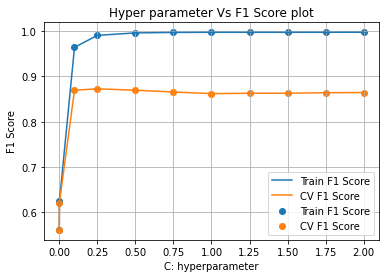

In [ ]:
svm = SVC(gamma='auto')
parameters = {'C':[ 0.0001, 0.001, 0.1, 0.25, 0.50, 0.75, 1, 1.25, 1.5, 1.75, 2.0], 'kernel': ['linear']}
clf = GridSearchCV(svm, parameters, cv=10, scoring='f1_micro', return_train_score=True)
clf.fit(Train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_C'])

train_score= results['mean_train_score']
cv_score = results['mean_test_score'] 
alpha =  results['param_C']

plt.plot(alpha, train_score, label='Train F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_score, label='CV F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha, train_score, label='Train F1 Score')
plt.scatter(alpha, cv_score, label='CV F1 Score')


plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("F1 Score")
plt.title("Hyper parameter Vs F1 Score plot")
plt.grid()
plt.show()

In [ ]:
clf.best_params_

{'C': 0.25, 'kernel': 'linear'}

Number of misclassified points  12.852664576802509
-------------------------------------------------- Confusion matrix --------------------------------------------------


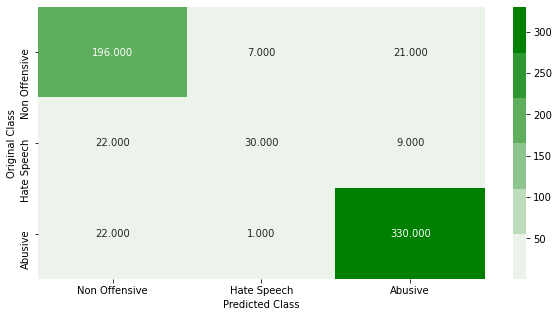

-------------------------------------------------- Precision matrix --------------------------------------------------


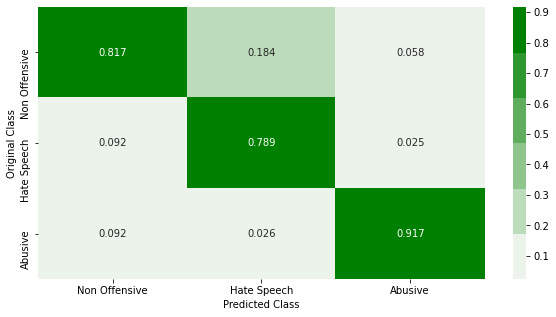

Sum of columns in precision matrix [1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


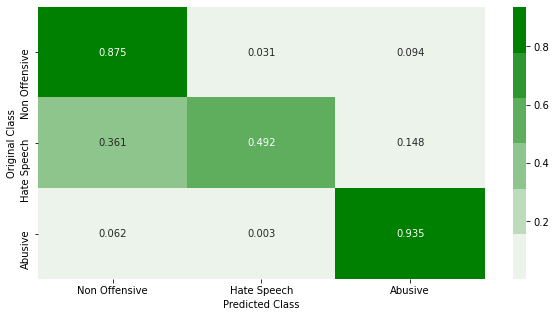

Sum of rows in Recall matrix [1. 1. 1.]


In [26]:
svm_clf = SVC(C=0.25, gamma='auto', kernel='linear')
svm_clf.fit(Train, y_train)
plot_confusion_matrix(y_test, svm_clf.predict(Test))

## 1.2 Support Vector Machine with RBF Kernel

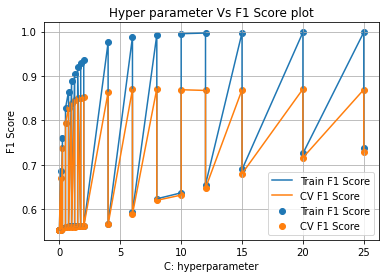

In [ ]:
svm = SVC(kernel='rbf')
parameters = {'C':[ 0.0001, 0.001, 0.1, 0.25, 0.50, 0.75, 1, 1.25, 1.5, 1.75, 2.0, 4, 6, 8, 10, 12, 15, 20, 25], 'gamma':['scale', 'auto'],  }
clf = GridSearchCV(svm, parameters, cv=10, scoring='f1_micro', return_train_score=True)
clf.fit(Train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_C'])

train_score= results['mean_train_score']
cv_score = results['mean_test_score'] 
alpha =  results['param_C']

plt.plot(alpha, train_score, label='Train F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_score, label='CV F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha, train_score, label='Train F1 Score')
plt.scatter(alpha, cv_score, label='CV F1 Score')


plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("F1 Score")
plt.title("Hyper parameter Vs F1 Score plot")
plt.grid()
plt.show()

In [ ]:
clf.best_params_

{'C': 8, 'gamma': 'scale'}

Number of misclassified points  13.479623824451412
-------------------------------------------------- Confusion matrix --------------------------------------------------


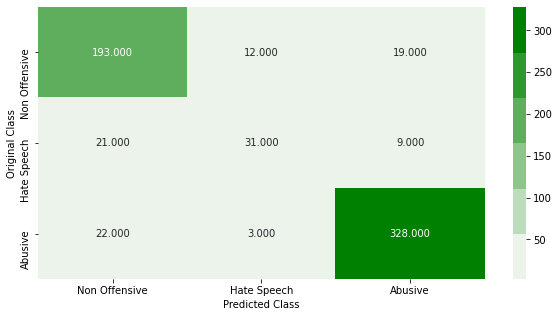

-------------------------------------------------- Precision matrix --------------------------------------------------


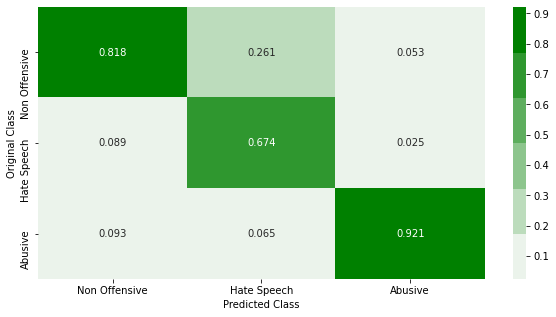

Sum of columns in precision matrix [1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


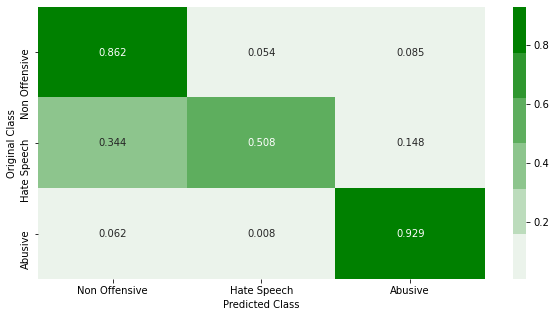

Sum of rows in Recall matrix [1. 1. 1.]


In [65]:
svm_clf_rbf = SVC(C=8, gamma='scale', kernel='rbf')
svm_clf_rbf.fit(Train, y_train)
plot_confusion_matrix(y_test, svm_clf_rbf.predict(Test))

## 1.3 Support Vector Machine with Polynominal Kernel

In [ ]:
svm = SVC(kernel='poly')
parameters = {'C':[ 0.0001, 0.001, 0.1, 1,  1.5, 2.0, 2.5, 3, 5, 8, 10, 15, 25, 50, 60, 75, 85, 95, 100, 110, 125, 150], \
              'gamma':['scale', 'auto'], 'degree': [2,3,4,5]  }
clf = GridSearchCV(svm, parameters, cv=10, scoring='f1_micro', return_train_score=True, n_jobs=-1)
clf.fit(Train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_C'])

train_score= results['mean_train_score']
cv_score = results['mean_test_score'] 
alpha =  results['param_C']

plt.plot(alpha, train_score, label='Train F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_score, label='CV F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha, train_score, label='Train F1 Score')
plt.scatter(alpha, cv_score, label='CV F1 Score')


plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("F1 Score")
plt.title("Hyper parameter Vs F1 Score plot")
plt.grid()
plt.show()

In [ ]:
clf.best_params_

{'C': 75, 'degree': 2, 'gamma': 'scale'}

Number of misclassified points  13.636363636363635
-------------------------------------------------- Confusion matrix --------------------------------------------------


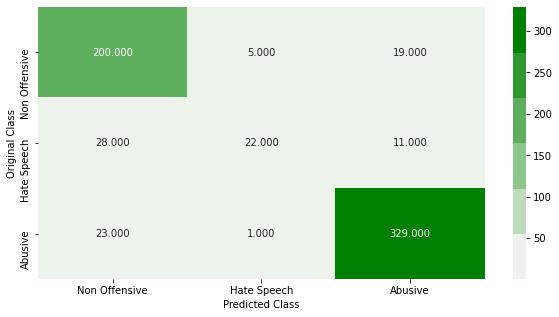

-------------------------------------------------- Precision matrix --------------------------------------------------


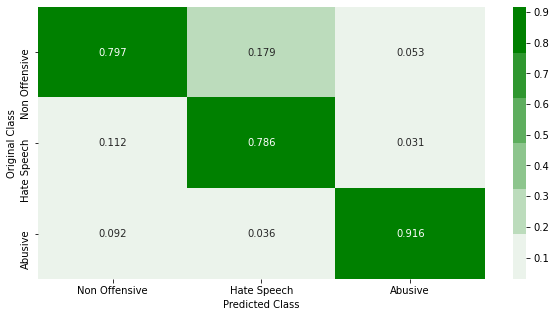

Sum of columns in precision matrix [1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


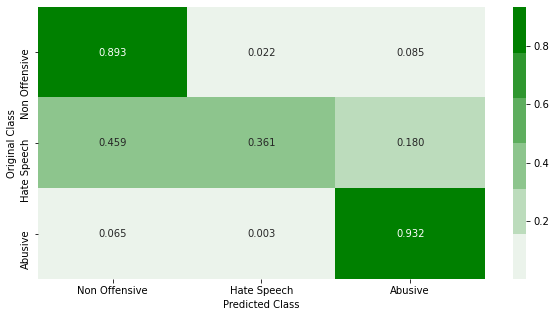

Sum of rows in Recall matrix [1. 1. 1.]


In [29]:
svm_clf_poly = SVC(C=75, gamma='scale', degree=2, kernel='poly')
svm_clf_poly.fit(Train, y_train)
plot_confusion_matrix(y_test, svm_clf_poly.predict(Test))

## 2. Logistic Regression

C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:54

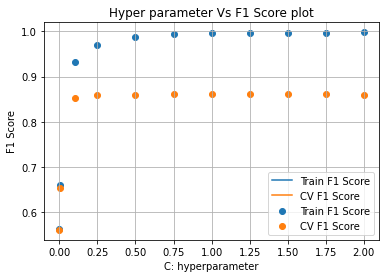

In [ ]:
LR = LogisticRegression(max_iter=500, random_state=42)
parameters = {'C':[ 0.0001, 0.001, 0.1, 0.25, 0.50, 0.75, 1, 1.25, 1.5, 1.75, 2.0], 'penalty':['l1', 'l2', 'elasticnet']}

clf = GridSearchCV(LR, parameters, cv=10, scoring='f1_micro', return_train_score=True)
clf.fit(Train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_C'])

train_score= results['mean_train_score']
cv_score = results['mean_test_score'] 
alpha =  results['param_C']

plt.plot(alpha, train_score, label='Train F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_score, label='CV F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha, train_score, label='Train F1 Score')
plt.scatter(alpha, cv_score, label='CV F1 Score')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("F1 Score")
plt.title("Hyper parameter Vs F1 Score plot")
plt.grid()
plt.show()

In [ ]:
clf.best_params_

{'C': 0.75, 'penalty': 'l2'}

Number of misclassified points  13.793103448275861
-------------------------------------------------- Confusion matrix --------------------------------------------------


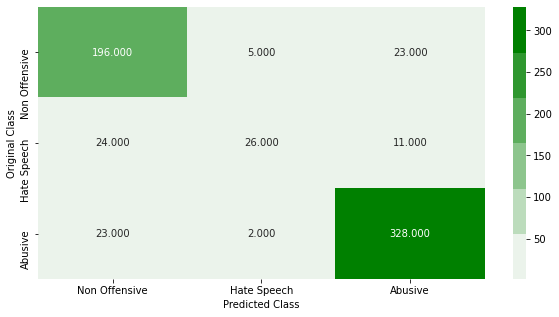

-------------------------------------------------- Precision matrix --------------------------------------------------


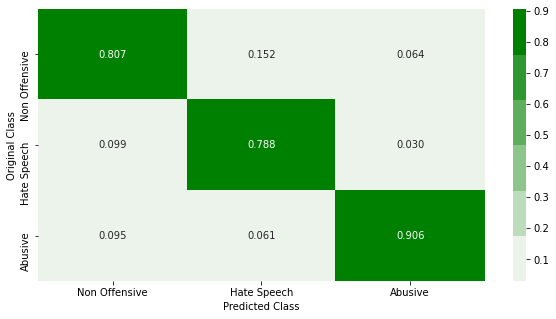

Sum of columns in precision matrix [1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


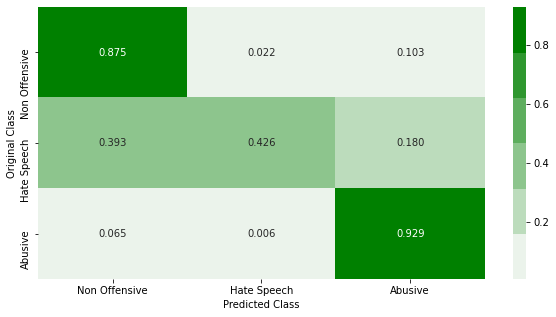

Sum of rows in Recall matrix [1. 1. 1.]


In [32]:
LR_clf = LogisticRegression(C= 0.75, max_iter=500, penalty='l2', random_state=42)
LR_clf.fit(Train, y_train)
plot_confusion_matrix(y_test, LR_clf.predict(Test))

## 3. Decision Tree Classifier

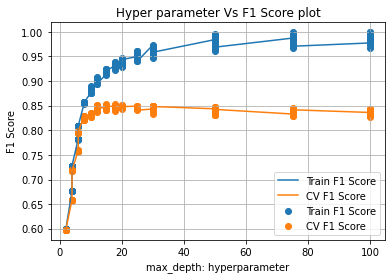

In [ ]:
from sklearn.tree import DecisionTreeClassifier

DTC = DecisionTreeClassifier()
parameters = {'criterion':['gini', 'entropy'], 'max_depth': [2, 4, 6, 8, 10, 12, 15, 18, 20, 25, 30, 50, 75, 100], \
             'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 10]}
clf = GridSearchCV(DTC, parameters, cv=10, scoring='f1_micro', n_jobs=-1, return_train_score=True)
clf.fit(Train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_max_depth'])

train_score= results['mean_train_score']
cv_score = results['mean_test_score'] 
alpha =  results['param_max_depth']

plt.plot(alpha, train_score, label='Train F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_score, label='CV F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha, train_score, label='Train F1 Score')
plt.scatter(alpha, cv_score, label='CV F1 Score')

plt.legend()
plt.xlabel("max_depth: hyperparameter")
plt.ylabel("F1 Score")
plt.title("Hyper parameter Vs F1 Score plot")
plt.grid()
plt.show()


In [ ]:
clf.best_params_

{'criterion': 'gini', 'max_depth': 18, 'min_samples_split': 2}

Number of misclassified points  15.360501567398119
-------------------------------------------------- Confusion matrix --------------------------------------------------


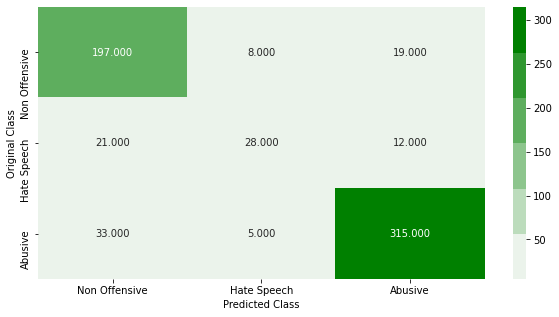

-------------------------------------------------- Precision matrix --------------------------------------------------


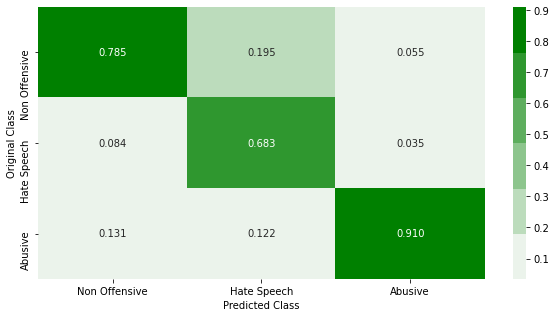

Sum of columns in precision matrix [1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


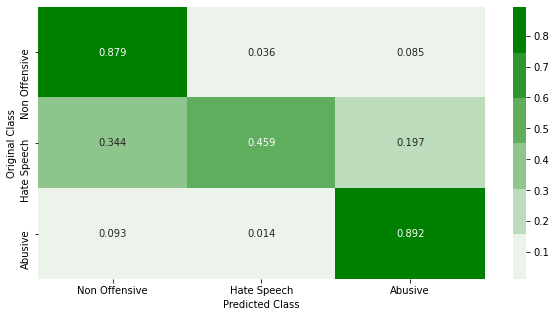

Sum of rows in Recall matrix [1. 1. 1.]


In [40]:
DTC_clf = DecisionTreeClassifier(criterion='gini', max_depth=18, min_samples_split=2)
DTC_clf.fit(Train, y_train)
plot_confusion_matrix(y_test, DTC_clf.predict(Test))

## 4. K - Nearest Neighbour Classifier

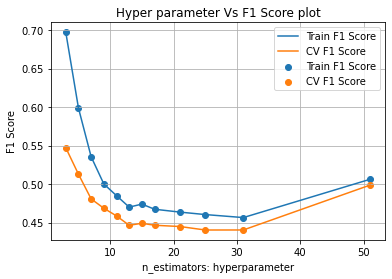

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
KNN = KNeighborsClassifier()
parameters = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15, 17, 21, 25, 31, 51, ]}
clf = GridSearchCV(KNN, parameters, cv=10, scoring='f1_macro', n_jobs=-1, return_train_score=True)
clf.fit(Train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_neighbors'])

train_score= results['mean_train_score']
cv_score = results['mean_test_score'] 
alpha =  results['param_n_neighbors']

plt.plot(alpha, train_score, label='Train F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_score, label='CV F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha, train_score, label='Train F1 Score')
plt.scatter(alpha, cv_score, label='CV F1 Score')

plt.legend()
plt.xlabel("n_neighbors: hyperparameter")
plt.ylabel("F1 Score")
plt.title("Hyper parameter Vs F1 Score plot")
plt.grid()
plt.show()

In [ ]:
clf.best_params_

{'n_neighbors': 3}

Number of misclassified points  27.11598746081505
-------------------------------------------------- Confusion matrix --------------------------------------------------


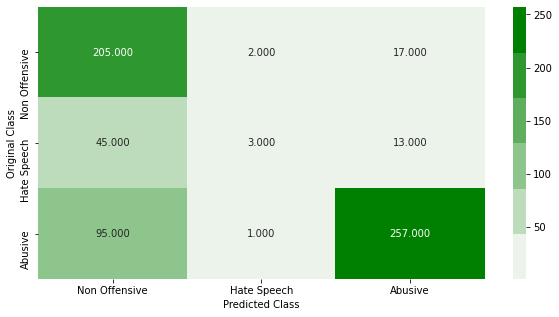

-------------------------------------------------- Precision matrix --------------------------------------------------


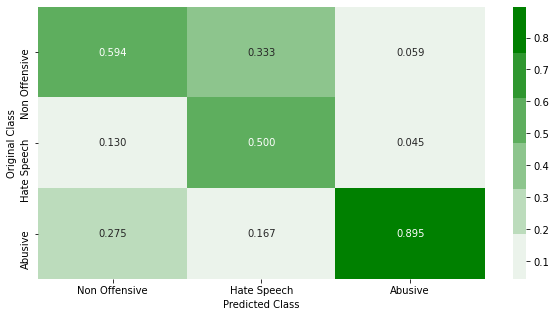

Sum of columns in precision matrix [1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


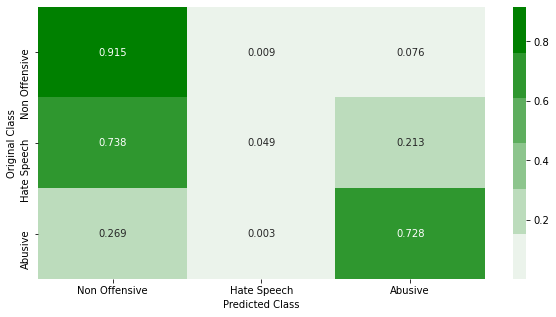

Sum of rows in Recall matrix [1. 1. 1.]


In [57]:
from sklearn.neighbors import KNeighborsClassifier
KNN_clf = KNeighborsClassifier(n_neighbors=3)
KNN_clf.fit(Train, y_train)
plot_confusion_matrix(y_test, KNN_clf.predict(Test))

## 5. Extra Tree Classifiers 

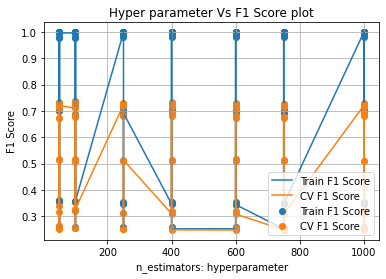

In [ ]:
ETC = ExtraTreesClassifier(n_jobs=-1)
parameters = {'n_estimators':[ 50,100,250, 400, 600, 750, 1000], 'criterion': ['gini', 'entropy'], \
              'max_depth': [5, 10, 20, 50, 100, 200, 300, 400, 500, 750]}
clf = GridSearchCV(ETC, parameters, cv=10, scoring='f1_macro', n_jobs=-1, return_train_score=True)
clf.fit(Train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_estimators'])

train_score= results['mean_train_score']
cv_score = results['mean_test_score'] 
alpha =  results['param_n_estimators']

plt.plot(alpha, train_score, label='Train F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_score, label='CV F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha, train_score, label='Train F1 Score')
plt.scatter(alpha, cv_score, label='CV F1 Score')

plt.legend()
plt.xlabel("n_estimators: hyperparameter")
plt.ylabel("F1 Score")
plt.title("Hyper parameter Vs F1 Score plot")
plt.grid()
plt.show()

In [ ]:
clf.best_params_

{'criterion': 'gini', 'max_depth': 20, 'n_estimators': 100}

Number of misclassified points  13.166144200626958
-------------------------------------------------- Confusion matrix --------------------------------------------------


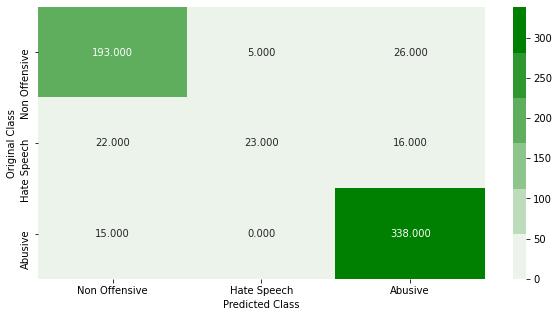

-------------------------------------------------- Precision matrix --------------------------------------------------


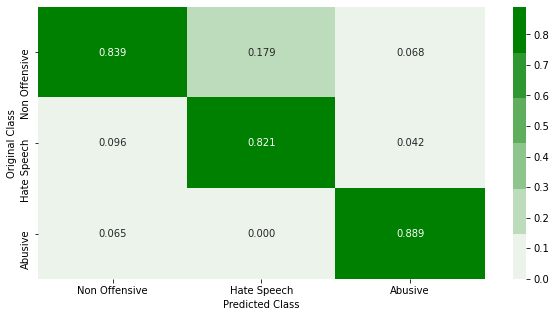

Sum of columns in precision matrix [1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


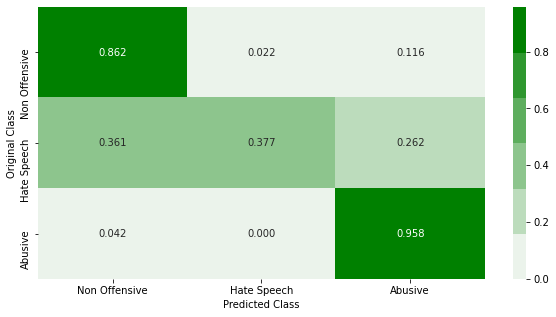

Sum of rows in Recall matrix [1. 1. 1.]


In [62]:
ETC_clf = ExtraTreesClassifier(criterion='gini', max_depth=200, n_estimators=500, n_jobs=-1)
ETC_clf.fit(Train, y_train)
plot_confusion_matrix(y_test, ETC_clf.predict(Test))

## 6. Random Forest Classifier

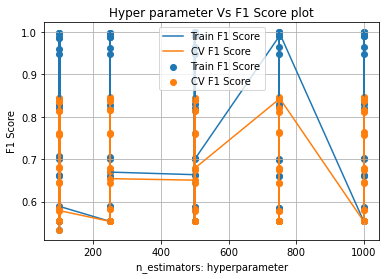

In [ ]:
RF = RandomForestClassifier(n_jobs=-1)
parameters={
     'n_estimators': [100, 250, 500, 750, 1000],
     'max_depth': [5,8,10, 20, 50, 100, 250, 500 ],
    'max_samples' : [0.6, 0.75, 1],
}
clf = GridSearchCV(RF, parameters, cv=10, scoring='f1_micro', n_jobs=-1, return_train_score=True)
clf.fit(Train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_estimators'])

train_score= results['mean_train_score']
cv_score = results['mean_test_score'] 
alpha =  results['param_n_estimators']

plt.plot(alpha, train_score, label='Train F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_score, label='CV F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha, train_score, label='Train F1 Score')
plt.scatter(alpha, cv_score, label='CV F1 Score')

plt.legend()
plt.xlabel("n_estimators: hyperparameter")
plt.ylabel("F1 Score")
plt.title("Hyper parameter Vs F1 Score plot")
plt.grid()
plt.show()

In [ ]:
clf.best_params_

{'max_depth': 250, 'max_samples': 0.75, 'n_estimators': 250}

Number of misclassified points  15.987460815047022
-------------------------------------------------- Confusion matrix --------------------------------------------------


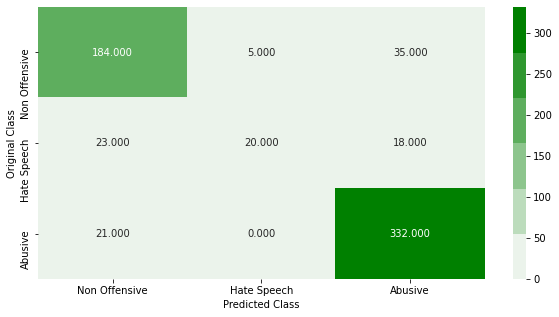

-------------------------------------------------- Precision matrix --------------------------------------------------


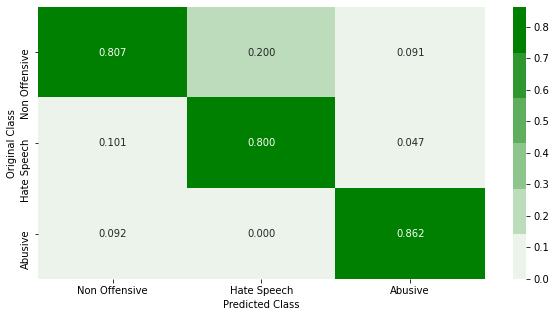

Sum of columns in precision matrix [1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


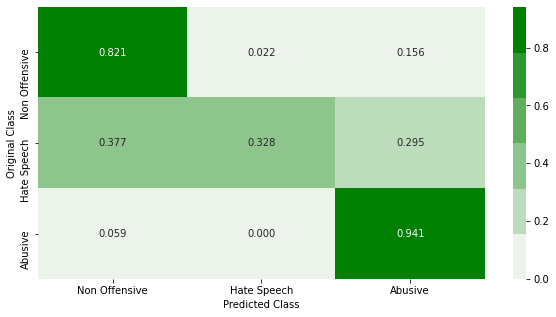

Sum of rows in Recall matrix [1. 1. 1.]


In [42]:
RF_clf = RandomForestClassifier(n_estimators=250, max_depth=250, max_samples=0.75, n_jobs=-1)
RF_clf.fit(Train, y_train)
plot_confusion_matrix(y_test, RF_clf.predict(Test))

## 7. XGBOOST Classifier

In [ ]:
from xgboost import XGBClassifier
XGB = XGBClassifier()
parameters={
    'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1, 2, 3, 5],
     'n_estimators':[100, 250, 500, 750, 1000],
     'max_depth':[5, 10, 20, 50, 100, 200, 350, 500],
    'colsample_bytree' : [0.6, 0.75, 1],
    'subsample': [0.6, 0.75, 1]
}

clf = GridSearchCV(XGB, parameters, cv=5, scoring='f1_macro', n_jobs=-1, return_train_score=True)
clf.fit(Train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_estimators'])

train_score= results['mean_train_score']
cv_score = results['mean_test_score'] 
alpha =  results['param_n_estimators']

plt.plot(alpha, train_score, label='Train F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_score, label='CV F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha, train_score, label='Train F1 Score')
plt.scatter(alpha, cv_score, label='CV F1 Score')

plt.legend()
plt.xlabel("n_estimators: hyperparameter")
plt.ylabel("F1 Score")
plt.title("Hyper parameter Vs F1 Score plot")
plt.grid()
plt.show()

In [ ]:
clf.best_params_

Number of misclassified points  12.225705329153605
-------------------------------------------------- Confusion matrix --------------------------------------------------


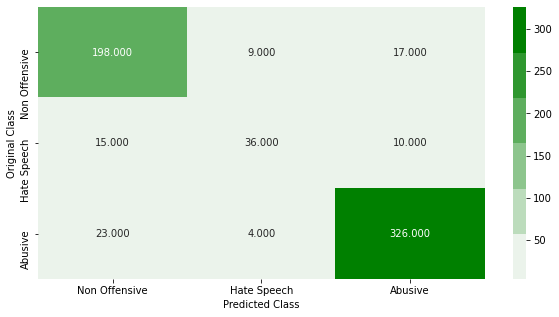

-------------------------------------------------- Precision matrix --------------------------------------------------


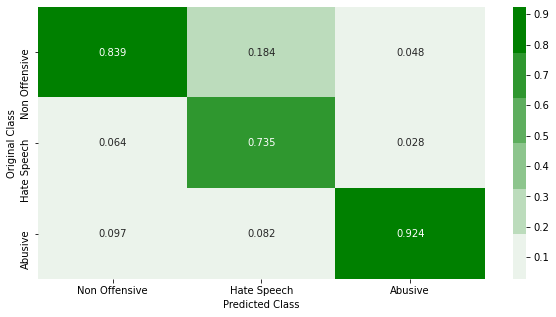

Sum of columns in precision matrix [1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


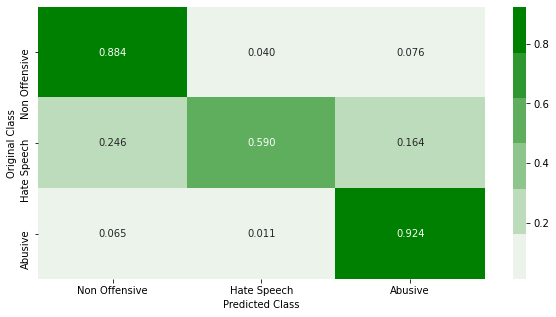

Sum of rows in Recall matrix [1. 1. 1.]


In [49]:

XGB_clf = XGBClassifier(depth= 10, learning_rate =0.75, iterations=100, n_jobs=-1)
XGB_clf.fit(Train, y_train)
plot_confusion_matrix(y_test, XGB_clf.predict(Test))

## 8. Light Gradient Boosting Tree Classifier

In [ ]:
from lightgbm import LGBMClassifier
LGBM = LGBMClassifier(n_jobs=-1)
parameters={'max_depth': [5, 10, 20, 50, 100, 200, 350, 500], 'min_data_in_leaf': [2,5,8,12,15,25,50], 'num_leaves': [20,50,100,250,500,750,1000,1500]}

clf = GridSearchCV(LGBM, parameters, cv=5, scoring='f1_macro', n_jobs=-1, return_train_score=True)
clf.fit(Train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_num_leaves'])

train_score= results['mean_train_score']
cv_score = results['mean_test_score'] 
alpha =  results['param_num_leaves']

plt.plot(alpha, train_score, label='Train F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_score, label='CV F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha, train_score, label='Train F1 Score')
plt.scatter(alpha, cv_score, label='CV F1 Score')

plt.legend()
plt.xlabel("n_estimators: hyperparameter")
plt.ylabel("F1 Score")
plt.title("Hyper parameter Vs F1 Score plot")
plt.grid()
plt.show()

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


Number of misclassified points  12.38244514106583
-------------------------------------------------- Confusion matrix --------------------------------------------------


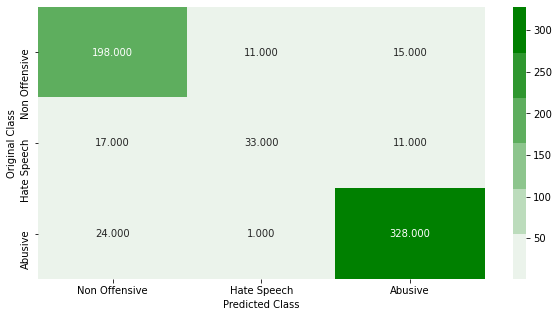

-------------------------------------------------- Precision matrix --------------------------------------------------


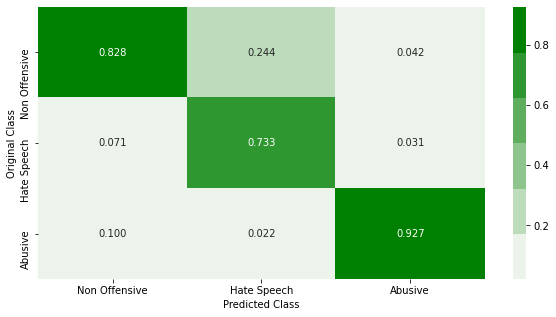

Sum of columns in precision matrix [1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


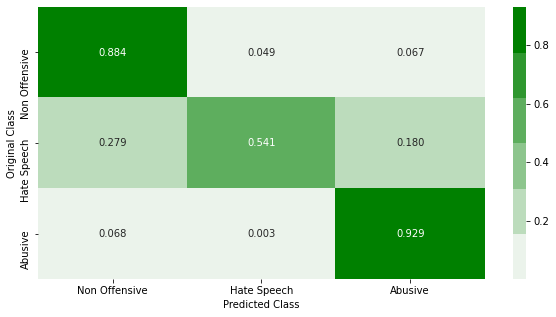

Sum of rows in Recall matrix [1. 1. 1.]


In [50]:
from lightgbm import LGBMClassifier
LGBM_clf = LGBMClassifier(max_depth= 10, min_data_in_leaf = 2, num_leaves=50, n_jobs=-1)
LGBM_clf.fit(Train, y_train)
plot_confusion_matrix(y_test, LGBM_clf.predict(Test))

## 9. CATBOOST Classifier 

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 32.2min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 271.8min
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed: 271.9min
[Parallel(n_jobs=-1)]: Done 662 tasks      | elapsed: 272.1min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 272.3min finished


0:	learn: 0.7541682	total: 3.7s	remaining: 6m 6s
1:	learn: 0.6360728	total: 5.36s	remaining: 4m 22s
2:	learn: 0.5693282	total: 7.01s	remaining: 3m 46s
3:	learn: 0.5148313	total: 8.67s	remaining: 3m 28s
4:	learn: 0.4984070	total: 10.3s	remaining: 3m 16s
5:	learn: 0.4848281	total: 12s	remaining: 3m 8s
6:	learn: 0.4714964	total: 13.7s	remaining: 3m 2s
7:	learn: 0.4491680	total: 15.4s	remaining: 2m 56s
8:	learn: 0.4321146	total: 17.1s	remaining: 2m 52s
9:	learn: 0.3929892	total: 18.7s	remaining: 2m 48s
10:	learn: 0.3794763	total: 20.4s	remaining: 2m 45s
11:	learn: 0.3719162	total: 22.1s	remaining: 2m 41s
12:	learn: 0.3666316	total: 23.8s	remaining: 2m 38s
13:	learn: 0.3630261	total: 25.4s	remaining: 2m 36s
14:	learn: 0.3584877	total: 27.1s	remaining: 2m 33s
15:	learn: 0.3524301	total: 28.8s	remaining: 2m 31s
16:	learn: 0.3474500	total: 30.5s	remaining: 2m 28s
17:	learn: 0.3443083	total: 32.2s	remaining: 2m 26s
18:	learn: 0.3397876	total: 33.9s	remaining: 2m 24s
19:	learn: 0.3306275	total: 

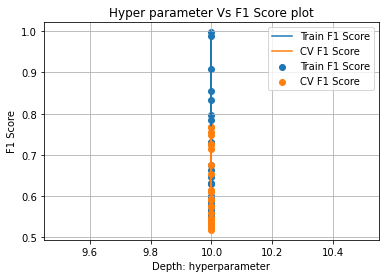

In [19]:
from catboost import CatBoostClassifier
CBC = CatBoostClassifier()
parameters={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'depth': [10, 20, 50, 100, 250, 500], \
            'iterations': [10,20,50,100,200]}

clf = GridSearchCV(CBC, parameters, cv=5, scoring='f1_macro', n_jobs=-1, return_train_score=True, verbose=5)
clf.fit(Train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_depth'])

train_score= results['mean_train_score']
cv_score = results['mean_test_score'] 
alpha =  results['param_depth']

plt.plot(alpha, train_score, label='Train F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_score, label='CV F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha, train_score, label='Train F1 Score')
plt.scatter(alpha, cv_score, label='CV F1 Score')

plt.legend()
plt.xlabel("Depth: hyperparameter")
plt.ylabel("F1 Score")
plt.title("Hyper parameter Vs F1 Score plot")
plt.grid()
plt.show()

In [20]:
clf.best_params_

{'depth': 10, 'iterations': 100, 'learning_rate': 1}

0:	learn: 0.7040039	total: 2.52s	remaining: 4m 9s
1:	learn: 0.5785192	total: 4.17s	remaining: 3m 24s
2:	learn: 0.5138431	total: 5.82s	remaining: 3m 8s
3:	learn: 0.4821347	total: 7.47s	remaining: 2m 59s
4:	learn: 0.4699597	total: 9.13s	remaining: 2m 53s
5:	learn: 0.4586953	total: 10.8s	remaining: 2m 48s
6:	learn: 0.4485450	total: 12.4s	remaining: 2m 44s
7:	learn: 0.4384956	total: 14.1s	remaining: 2m 41s
8:	learn: 0.4296931	total: 15.7s	remaining: 2m 39s
9:	learn: 0.4061161	total: 17.4s	remaining: 2m 36s
10:	learn: 0.3998492	total: 19.1s	remaining: 2m 34s
11:	learn: 0.3961087	total: 20.7s	remaining: 2m 32s
12:	learn: 0.3868323	total: 22.4s	remaining: 2m 29s
13:	learn: 0.3615598	total: 24.1s	remaining: 2m 27s
14:	learn: 0.3532030	total: 25.8s	remaining: 2m 26s
15:	learn: 0.3500194	total: 27.4s	remaining: 2m 24s
16:	learn: 0.3329152	total: 29.1s	remaining: 2m 22s
17:	learn: 0.3271658	total: 30.8s	remaining: 2m 20s
18:	learn: 0.3233190	total: 32.4s	remaining: 2m 18s
19:	learn: 0.3211515	tot

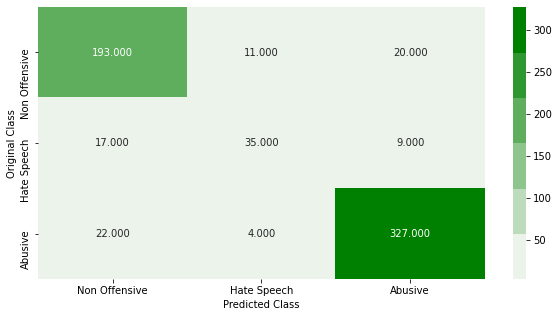

-------------------------------------------------- Precision matrix --------------------------------------------------


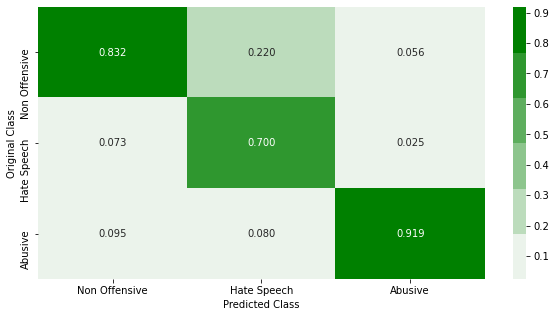

Sum of columns in precision matrix [1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


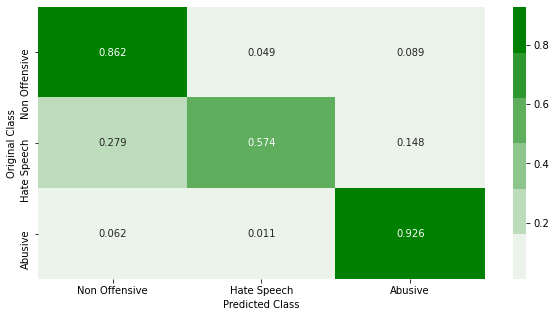

Sum of rows in Recall matrix [1. 1. 1.]


In [54]:
from catboost import CatBoostClassifier
CBC_clf = CatBoostClassifier(depth= 10, learning_rate =1, iterations=100)
CBC_clf.fit(Train, y_train)
plot_confusion_matrix(y_test, CBC_clf.predict(Test))

## Summary

In [60]:
from prettytable import PrettyTable
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score
myTable = PrettyTable(["Model","Train / Test", "Accuray", "F1-Score", "Precison", "Recall"])
  
# Add rows
myTable.add_row(["KNN", "Train", np.round(accuracy_score(y_train, KNN_clf.predict(Train)), 6), np.round(f1_score(y_train, KNN_clf.predict(Train),\
                average='macro'), 6), np.round(precision_score(y_train, KNN_clf.predict(Train), average='macro'), 6), \
                 np.round(recall_score(y_train, KNN_clf.predict(Train), average='macro'), 6)])

myTable.add_row(["KNN", "Test", np.round(accuracy_score(y_test, svm_clf.predict(Test)), 6), np.round(f1_score(y_test, svm_clf.predict(Test),\
                average='macro'), 6), np.round(precision_score(y_test, svm_clf.predict(Test), average='macro'), 6), \
                 np.round(recall_score(y_test, svm_clf.predict(Test), average='macro'), 6)])

myTable.add_row(["SVC-Linear", "Train", np.round(accuracy_score(y_train, svm_clf.predict(Train)), 6), np.round(f1_score(y_train, svm_clf.predict(Train),\
                average='macro'), 6), np.round(precision_score(y_train, svm_clf.predict(Train), average='macro'), 6), \
                 np.round(recall_score(y_train, svm_clf.predict(Train), average='macro'), 6)])

myTable.add_row(["SVC-Linear", "Test", np.round(accuracy_score(y_test, svm_clf.predict(Test)), 6), np.round(f1_score(y_test, svm_clf.predict(Test),\
                average='macro'), 6), np.round(precision_score(y_test, svm_clf.predict(Test), average='macro'), 6), \
                 np.round(recall_score(y_test, svm_clf.predict(Test), average='macro'), 6)])

myTable.add_row(["SVC-RBF", "Train", np.round(accuracy_score(y_train, svm_clf_rbf.predict(Train)), 6), np.round(f1_score(y_train, svm_clf_rbf.predict(Train),\
                average='macro'), 6), np.round(precision_score(y_train, svm_clf_rbf.predict(Train), average='macro'), 6), \
                 np.round(recall_score(y_train, svm_clf_rbf.predict(Train), average='macro'), 6)])

myTable.add_row(["SVC-RBF", "Test", np.round(accuracy_score(y_test, svm_clf_rbf.predict(Test)), 6), np.round(f1_score(y_test, svm_clf_rbf.predict(Test),\
                average='macro'), 6), np.round(precision_score(y_test, svm_clf_rbf.predict(Test), average='macro'), 6), \
                 np.round(recall_score(y_test, svm_clf_rbf.predict(Test), average='macro'), 6)])

myTable.add_row(["SVC-Poly", "Train", np.round(accuracy_score(y_train, svm_clf_poly.predict(Train)), 6), np.round(f1_score(y_train, svm_clf_poly.predict(Train),\
                average='macro'), 6), np.round(precision_score(y_train, svm_clf_poly.predict(Train), average='macro'), 6), \
                 np.round(recall_score(y_train, svm_clf_poly.predict(Train), average='macro'), 6)])

myTable.add_row(["SVC-Poly", "Test", np.round(accuracy_score(y_test, svm_clf_poly.predict(Test)), 6), np.round(f1_score(y_test, svm_clf_poly.predict(Test),\
                average='macro'), 6), np.round(precision_score(y_test, svm_clf_poly.predict(Test), average='macro'), 6), \
                 np.round(recall_score(y_test, svm_clf_poly.predict(Test), average='macro'), 6)])

myTable.add_row(["Logistic Regression","Train", np.round(accuracy_score(y_train, LR_clf.predict(Train)), 6), np.round(f1_score(y_train, LR_clf.predict(Train),\
                average='macro'), 6), np.round(precision_score(y_train, LR_clf.predict(Train), average='macro'), 6),\
                 np.round(recall_score(y_train, LR_clf.predict(Train), average='macro'), 6)])

myTable.add_row(["Logistic Regression","Test", np.round(accuracy_score(y_test, LR_clf.predict(Test)), 6), np.round(f1_score(y_test, LR_clf.predict(Test),\
                average='macro'), 6), np.round(precision_score(y_test, LR_clf.predict(Test), average='macro'), 6),\
                 np.round(recall_score(y_test, LR_clf.predict(Test), average='macro'), 6)])

myTable.add_row(["Decision Tree","Train", np.round(accuracy_score(y_train, DTC_clf.predict(Train)), 6), np.round(f1_score(y_train, DTC_clf.predict(Train),\
                average='macro'), 6), np.round(precision_score(y_train, DTC_clf.predict(Train), average='macro'), 6),\
                 np.round(recall_score(y_train, DTC_clf.predict(Train), average='macro'), 6)])

myTable.add_row(["Decision Tree","Test", np.round(accuracy_score(y_test, DTC_clf.predict(Test)), 6), np.round(f1_score(y_test, DTC_clf.predict(Test),\
                average='macro'), 6), np.round(precision_score(y_test, DTC_clf.predict(Test), average='macro'), 6),\
                 np.round(recall_score(y_test, DTC_clf.predict(Test), average='macro'), 6)])

myTable.add_row(["Extra Tree","Train", np.round(accuracy_score(y_train, ETC_clf.predict(Train)), 6), np.round(f1_score(y_train, ETC_clf.predict(Train),\
                average='macro'), 6), np.round(precision_score(y_train, ETC_clf.predict(Train), average='macro'), 6),\
                 np.round(recall_score(y_train, ETC_clf.predict(Train), average='macro'), 6)])

myTable.add_row(["Extra Tree","Test", np.round(accuracy_score(y_test, ETC_clf.predict(Test)), 6), np.round(f1_score(y_test, ETC_clf.predict(Test),\
                average='macro'), 6), np.round(precision_score(y_test, ETC_clf.predict(Test), average='macro'), 6),\
                 np.round(recall_score(y_test, ETC_clf.predict(Test), average='macro'), 6)])

myTable.add_row(["Random Forest","Train", np.round(accuracy_score(y_train, RF_clf.predict(Train)), 6), np.round(f1_score(y_train, RF_clf.predict(Train),\
                average='macro'), 6), np.round(precision_score(y_train, RF_clf.predict(Train), average='macro'), 6),\
                 np.round(recall_score(y_train, RF_clf.predict(Train), average='macro'), 6)])

myTable.add_row(["Random Forest","Test", np.round(accuracy_score(y_test, RF_clf.predict(Test)), 6), np.round(f1_score(y_test, RF_clf.predict(Test),\
                average='macro'), 6), np.round(precision_score(y_test, RF_clf.predict(Test), average='macro'), 6),\
                 np.round(recall_score(y_test, RF_clf.predict(Test), average='macro'), 6)])

myTable.add_row(["XGBOOST","Train", np.round(accuracy_score(y_train, XGB_clf.predict(Train)), 6), np.round(f1_score(y_train, XGB_clf.predict(Train),\
                average='macro'), 6), np.round(precision_score(y_train, XGB_clf.predict(Train), average='macro'), 6),\
                 np.round(recall_score(y_train, XGB_clf.predict(Train), average='macro'), 6)])

myTable.add_row(["XGBOOST","Test", np.round(accuracy_score(y_test, XGB_clf.predict(Test)), 6), np.round(f1_score(y_test, XGB_clf.predict(Test),\
                average='macro'), 6), np.round(precision_score(y_test, XGB_clf.predict(Test), average='macro'), 6),\
                 np.round(recall_score(y_test, XGB_clf.predict(Test), average='macro'), 6)])

myTable.add_row(["Light-GBM","Train", np.round(accuracy_score(y_train, LGBM_clf.predict(Train)), 6), np.round(f1_score(y_train, LGBM_clf.predict(Train),\
                average='macro'), 6), np.round(precision_score(y_train, LGBM_clf.predict(Train), average='macro'), 6),\
                 np.round(recall_score(y_train, LGBM_clf.predict(Train), average='macro'), 6)])

myTable.add_row(["Light-GBM","Test", np.round(accuracy_score(y_test, LGBM_clf.predict(Test)), 6), np.round(f1_score(y_test, LGBM_clf.predict(Test),\
                average='macro'), 6), np.round(precision_score(y_test, LGBM_clf.predict(Test), average='macro'), 6),\
                 np.round(recall_score(y_test, LGBM_clf.predict(Test), average='macro'), 6)])

myTable.add_row(["CatBoost","Train", np.round(accuracy_score(y_train, CBC_clf.predict(Train)), 6), np.round(f1_score(y_train, CBC_clf.predict(Train),\
                average='macro'), 6), np.round(precision_score(y_train, CBC_clf.predict(Train), average='macro'), 6),\
                 np.round(recall_score(y_train, CBC_clf.predict(Train), average='macro'), 6)])

myTable.add_row(["CatBoost","Test", np.round(accuracy_score(y_test, CBC_clf.predict(Test)), 6), np.round(f1_score(y_test, CBC_clf.predict(Test),\
                average='macro'), 6), np.round(precision_score(y_test, CBC_clf.predict(Test), average='macro'), 6),\
                 np.round(recall_score(y_test, CBC_clf.predict(Test), average='macro'), 6)])


print(myTable)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


+---------------------+--------------+----------+----------+----------+----------+
|        Model        | Train / Test | Accuray  | F1-Score | Precison |  Recall  |
+---------------------+--------------+----------+----------+----------+----------+
|         KNN         |    Train     | 0.820463 | 0.694628 | 0.858224 | 0.680417 |
|         KNN         |     Test     | 0.871473 | 0.792185 | 0.840936 | 0.767216 |
|      SVC-Linear     |    Train     | 0.989024 | 0.983185 | 0.989127 | 0.977604 |
|      SVC-Linear     |     Test     | 0.871473 | 0.792185 | 0.840936 | 0.767216 |
|       SVC-RBF       |    Train     | 0.990592 | 0.985573 | 0.991417 | 0.980096 |
|       SVC-RBF       |     Test     | 0.873041 | 0.789207 | 0.840219 | 0.764184 |
|       SVC-Poly      |    Train     | 0.993336 | 0.989978 | 0.992576 | 0.987455 |
|       SVC-Poly      |     Test     | 0.863636 | 0.753548 | 0.832987 | 0.728508 |
| Logistic Regression |    Train     | 0.990984 | 0.984856 |  0.9923  | 0.977914 |
| Lo

From above three First cut model: Our SVM with linear kernel is performing well overall specially for Hate Speech category. As our Hate Speech
category is very less in number. More Data for Hate Speech will be helpful to increase overall model performance.  